In [1]:
import numpy as np
import matplotlib.pyplot as plt
from models.classifier import BinaryClassifier
import torch
from torch.utils.data import TensorDataset
from tqdm.auto import trange
from sklearn.model_selection import train_test_split
from models.flow import Flow
# from models.fair import BinaryFair
from models.my_fair import BinaryFair
from utils.StatisticalDistance import EmpiricalStatisticalDistance
from models.galton import Galton
from utils.DataSplitting import *

%load_ext autoreload
%autoreload 2


## Generate Split Data 

In [2]:
data, labels, context = gen_galton_data(2/3, 100, sigma=0.4, all_high_res=False)
data_train, data_test, labels_train, labels_test, context_train, context_test = train_test_split(data, labels, context, test_size=0.1) 
data_set_labels_train = TensorDataset(data_train, labels_train) #For label classifier, use data and labels but not context
data_generator_labels_train = torch.utils.data.DataLoader(data_set_labels_train, **params)

data_set_context_train = TensorDataset(data_train, context_train) #For adversairal classifier, use data and context but not labels
data_generator_context_train = torch.utils.data.DataLoader(data_set_context_train, **params)

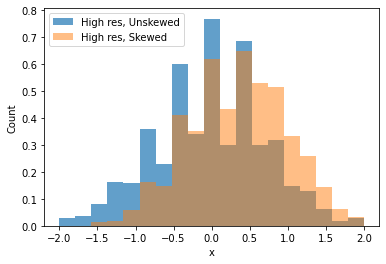

In [7]:
plt.hist(np.array(data_test[labels_test==1]),bins=np.linspace(-2,2,20), alpha=0.7, label="High res, Unskewed", density=True)
plt.hist(np.array(data_test[labels_test==0]),bins=np.linspace(-2,2,20), alpha=0.5, label="High res, Skewed", density=True)
plt.xlabel("x")
plt.ylabel("Count")
plt.legend()

plt.show()

In [ ]:
#Get label and adversarial accuracy on raw data
#TODO: Calculate analytic accuracy based on overlap of (Gaussian?) distributions
label_classifier = BinaryClassifier(data_dim=data_train.shape[-1])
label_classifier.fit(data_generator_labels_train)

adversarial_classifier = BinaryClassifier(data_dim=data_train.shape[-1])
adversarial_classifier.fit(data_generator_context_train)

baseline_high_res_label_acc = label_classifier.accuracy(data_test, labels_test)
adv_acc = adversarial_classifier.accuracy(data_test, context_test)

print("Label accuracy:", baseline_high_res_label_acc, "Adversarial accuracy:", adv_acc)


In [3]:
# Parameters
params = {'batch_size': 128,
          'shuffle': True}

data, labels, context = gen_galton_data(2/3, 100, sigma=0.4)
data_train, data_test, labels_train, labels_test, context_train, context_test = train_test_split(data, labels, context, test_size=0.1) 
data_set_labels_train = TensorDataset(data_train, labels_train) #For label classifier, use data and labels but not context
data_generator_labels_train = torch.utils.data.DataLoader(data_set_labels_train, **params)

data_set_context_train = TensorDataset(data_train, context_train) #For adversairal classifier, use data and context but not labels
data_generator_context_train = torch.utils.data.DataLoader(data_set_context_train, **params)

In [49]:
#Get label and adversarial accuracy on raw data
#TODO: Calculate analytic accuracy based on overlap of (Gaussian?) distributions
label_classifier = BinaryClassifier(data_dim=data_train.shape[-1])
label_classifier.fit(data_generator_labels_train)

adversarial_classifier = BinaryClassifier(data_dim=data_train.shape[-1])
adversarial_classifier.fit(data_generator_context_train)

baseline_label_acc = label_classifier.accuracy(data_test, labels_test)
adv_acc = adversarial_classifier.accuracy(data_test, context_test)

print("Label accuracy:", baseline_label_acc, "Adversarial accuracy:", adv_acc)


100%|██████████| 10000/10000 [00:16<00:00, 610.10it/s]

Label accuracy: 0.6019999980926514 Adversarial accuracy: 0.5799999833106995


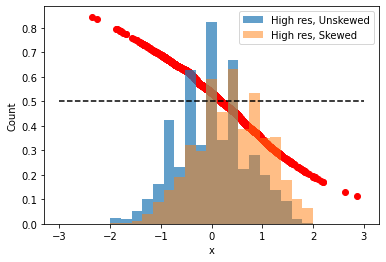

In [4]:
plt.hist(np.array(data_test[labels_test==1]),bins=np.linspace(-2,2,20), alpha=0.7, label="High res, Unskewed", density=True)
plt.hist(np.array(data_test[labels_test==0]),bins=np.linspace(-2,2,20), alpha=0.5, label="High res, Skewed", density=True)
plt.xlabel("x")
plt.ylabel("Count")
plt.legend()
plt.scatter(data_test.detach().numpy(), label_classifier.forward(data_test).sigmoid().detach().numpy(), color='red') #Sigmoid for density comparison

plt.plot(np.linspace(-3,3,100), 0.5*np.ones(100), 'k--')

plt.show()

## Introducing Fair Flows

### Probability Flow

In [16]:
#Treating this probability flow as part of the data generation process. Samples from p_0, p_1
probability_flow = Flow(data_dim=data_train.shape[-1], 
                  context_dim=data_train.shape[-1], #for alpha=1 the labels and contexts are the same
                  n_layers = 3,
                  transform_type = 'MaskedPiecewiseQuadraticAutoregressiveTransform', # ? Try Rational quadratic?
                  num_bins = 50,
                  tails='linear',
                  tail_bound=6.0,
                  gamma = 0.5,
        )
optimizer = torch.optim.AdamW(probability_flow.parameters(), lr=1e-4, weight_decay=1e-4)

In [17]:
data_set_context_train = TensorDataset(data_train, labels_train, context_train) #For probability flow, learn distributions conditioned on context
data_generator_context_train = torch.utils.data.DataLoader(data_set_context_train, **params)

# data_set_labels_train = TensorDataset(data_train, labels_train,) #For label classifier, use data and labels but not context
# data_generator_labels_train = torch.utils.data.DataLoader(data_set_labels_train, **params)

In [18]:
n_steps_prob = 4000
probability_loss = []

probability_flow.train()
for n_step in trange(n_steps_prob):
    data, labels, context = next(iter(data_generator_context_train))
    context=context.unsqueeze(1)

    optimizer.zero_grad()

    loss = probability_flow.prob_flow_loss(data, labels, context)
    probability_loss.append(loss.item())

    loss.backward()
    optimizer.step()
probability_flow.eval();

100%|██████████| 4000/4000 [00:50<00:00, 79.79it/s]


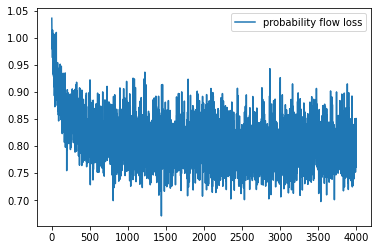

In [19]:
plt.plot(probability_loss, label="probability flow loss")
plt.legend()
plt.show()

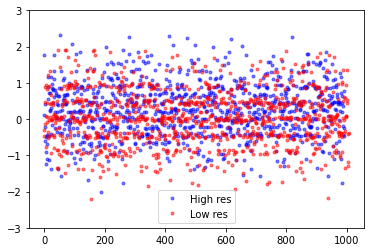

In [20]:
plt.plot(data_test[context_test==1],'b.',label="High res", alpha=0.5)
plt.plot(data_test[context_test==0], 'r.', label="Low res", alpha=0.5)
plt.ylim(-3, 3)
plt.legend()
plt.show()

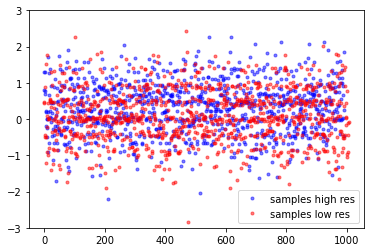

In [21]:
samples = probability_flow._sample(num_samples=1, context=context_test.unsqueeze(1))
plt.plot(samples.squeeze().detach().numpy()[context_test.squeeze().numpy()==1], 'b.', alpha=0.5, label="samples high res")
plt.plot(samples.squeeze().detach().numpy()[context_test.squeeze().numpy()==0], 'r.', alpha=0.5, label="samples low res")
plt.ylim(-3, 3)
plt.legend()
plt.show()

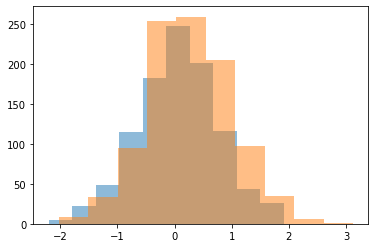

In [22]:
with torch.no_grad():
    plt.hist(data_test[(context_test==0).flatten()].T, alpha=0.5)
    plt.hist(data_test[(context_test==1).flatten()].T, alpha=0.5)


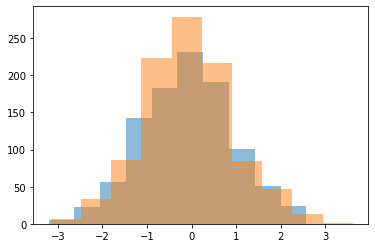

In [23]:
with torch.no_grad():
    plt.hist((probability_flow._transform(data_test[(context_test==0)], context_test[(context_test==0)].unsqueeze(1)))[0].T, alpha=0.5)
    plt.hist((probability_flow._transform(data_test[(context_test==1)], context_test[(context_test==1)].unsqueeze(1)))[0].T, alpha=0.5)


In [24]:
with torch.no_grad():
    embedded_data_train, _ = probability_flow._transform(data_train, context_train.unsqueeze(1))
    embedded_data_test, _ = probability_flow._transform(data_test, context_test.unsqueeze(1))

In [25]:
embedded_data_set_labels_train = TensorDataset(embedded_data_train, labels_train) #For label classifier, use data and labels but not context
embedded_data_generator_labels_train = torch.utils.data.DataLoader(embedded_data_set_labels_train, **params)

embedded_data_set_context_train = TensorDataset(embedded_data_train, context_train) #For adversairal classifier, use data and context but not labels
embedded_data_generator_context_train = torch.utils.data.DataLoader(embedded_data_set_context_train, **params)

In [26]:
#Get label and adversarial accuracy on embedded data (gamma = 0.5)
label_classifier = BinaryClassifier(data_dim=embedded_data_train.shape[-1])
label_classifier.fit(embedded_data_generator_labels_train)

adversarial_classifier = BinaryClassifier(data_dim=embedded_data_train.shape[-1])
adversarial_classifier.fit(embedded_data_generator_context_train)

probability_embedded_label_acc = label_classifier.accuracy(embedded_data_test, labels_test)
probability_adv_acc = adversarial_classifier.accuracy(embedded_data_test, context_test)

print("P-flow Label accuracy:", probability_embedded_label_acc, "P-flow Adversarial accuracy:", probability_adv_acc)


100%|██████████| 10000/10000 [00:15<00:00, 633.17it/s]

P-flow Label accuracy: 0.6000000238418579 P-flow Adversarial accuracy: 0.5015000104904175


In [70]:
#Get label and adversarial accuracy on embedded data (gamma = 1.0)
#TODO: Calculate analytic accuracy based on overlap of (Gaussian?) distributions
label_classifier = BinaryClassifier(data_dim=embedded_data_train.shape[-1])
label_classifier.fit(embedded_data_generator_labels_train)

adversarial_classifier = BinaryClassifier(data_dim=embedded_data_train.shape[-1])
adversarial_classifier.fit(embedded_data_generator_context_train)

probability_embedded_label_acc = label_classifier.accuracy(embedded_data_test, labels_test)
probability_adv_acc = adversarial_classifier.accuracy(embedded_data_test, context_test)

print("P-flow Label accuracy:", probability_embedded_label_acc, "P-flow Adversarial accuracy:", probability_adv_acc)


100%|██████████| 10000/10000 [00:15<00:00, 628.59it/s]

P-flow Label accuracy: 0.5770000219345093 P-flow Adversarial accuracy: 0.5090000033378601


In [27]:
gammas = [0.0, 0.02, 0.1, 0.2, 0.9]
prob_flows = []
n_steps_prob = 3000

for gamma in gammas:
    probability_flow = Flow(data_dim=data_train.shape[-1], 
                  context_dim=data_train.shape[-1], #for alpha=1 the labels and contexts are the same
                  n_layers = 3,
                  transform_type = 'MaskedPiecewiseQuadraticAutoregressiveTransform', # ? Try Rational quadratic?
                  num_bins = 50,
                  tails='linear',
                  tail_bound=6.0,
                  gamma = gamma,
        )
    optimizer = torch.optim.AdamW(probability_flow.parameters(), lr=1e-4, weight_decay=1e-4)


    probability_flow.train()
    for n_step in trange(n_steps_prob):
        data, labels, context = next(iter(data_generator_context_train))
        context=context.unsqueeze(1)

        optimizer.zero_grad()

        loss = probability_flow.prob_flow_loss(data, labels, context)
        probability_loss.append(loss.item())

        loss.backward()
        optimizer.step()
    probability_flow.eval();

    prob_flows.append(probability_flow)
    

 30%|███       | 904/3000 [00:11<00:26, 79.83it/s]

In [ ]:
label_accs = []
adv_accs = []
for prob_flow in prob_flows:

    with torch.no_grad():
        embedded_data_train, _ = prob_flow._transform(data_train, context_train.unsqueeze(1))
        embedded_data_test, _ = prob_flow._transform(data_test, context_test.unsqueeze(1))

    embedded_data_set_labels_train = TensorDataset(embedded_data_train, labels_train) #For label classifier, use data and labels but not context
    embedded_data_generator_labels_train = torch.utils.data.DataLoader(embedded_data_set_labels_train, **params)

    embedded_data_set_context_train = TensorDataset(embedded_data_train, context_train) #For adversairal classifier, use data and context but not labels
    embedded_data_generator_context_train = torch.utils.data.DataLoader(embedded_data_set_context_train, **params)

    label_classifier = BinaryClassifier(data_dim=embedded_data_train.shape[-1])
    label_classifier.fit(embedded_data_generator_labels_train)

    adversarial_classifier = BinaryClassifier(data_dim=embedded_data_train.shape[-1])
    adversarial_classifier.fit(embedded_data_generator_context_train)

    probability_embedded_label_acc = label_classifier.accuracy(embedded_data_test, labels_test)
    probability_adv_acc = adversarial_classifier.accuracy(embedded_data_test, context_test)

    label_accs.append(probability_embedded_label_acc)
    adv_accs.append(probability_adv_acc)

In [ ]:
plt.plot(gammas, label_accs, label='embedded label accuracy')
plt.plot(gammas, adv_accs, label='adversarial accuracy')
# plt.plot(np.linspace(0,1,10),np.ones(10)*baseline_label_acc, 'k--', label='baseline label accuracy')
# plt.plot(np.linspace(0,1,10),np.ones(10)*baseline_high_res_label_acc, 'k-.', label='baseline high res label accuracy')


plt.xlabel('gamma')
plt.ylabel('Accuracy')

plt.legend()
# plt.savefig('single_flow_accuracy.png')
plt.show()

### Fair Normalizing Flows

In [30]:
label_0_train_generator, label_1_train_generator, label_0_test_generator, label_1_test_generator = get_fair_generators(data_train, labels_train, context_train, data_test, labels_test, context_test)

In [120]:
#Create and train fair normalizing flows
gammas = [0.0, 0.02, 0.1, 0.2, 0.9]
Fairs = []
for gamma in gammas:
    Fair = BinaryFair(data_dim=data_train.shape[-1], 
                    context_dim=data_train.shape[-1],
                    flow_n_layers = 2,
                    flow_transform_type = 'MaskedPiecewiseQuadraticAutoregressiveTransform', 
                    classifier_hidden_dim = 32,
                    classifier_n_layers = 2,
                    classifier_activation = 'ReLU',
                    num_bins = 50,
                    tails='linear',
                    tail_bound=6.0,
                    gamma=gamma
                    )
    Fair.fit(label_0_train_generator, label_1_train_generator, probability_flow, n_steps=4000) #4000 is good for now

    Fairs.append(Fair)


100%|██████████| 4000/4000 [05:12<00:00, 12.78it/s]


In [97]:
#Calculate Statistical Distances
stat_dists = []
for fair in Fairs:
    stat_dist, _, _ = fair.optimal_adversary(label_0_test_generator, label_1_test_generator, probability_func=probability_flow)
    stat_dists.append(abs(stat_dist)) #? why is the statistical distance negative? Should go over this calculation again to see if this makes sense
print(stat_dists)

[tensor(0.9176), tensor(0.2787), tensor(0.0804), tensor(0.1729), tensor(0.0264)]


In [13]:
#Calculate Statistical Distances
stat_dists = []
for fair in Fairs:
    stat_dist, _, _ = fair.optimal_adversary(label_0_test_generator, label_1_test_generator, probability_func=probability_flow)
    stat_dists.append(abs(stat_dist)) #? why is the statistical distance negative? Should go over this calculation again to see if this makes sense
print(stat_dists)

[tensor(0.8927), tensor(0.2993), tensor(0.1471), tensor(0.0306), tensor(0.)]


In [98]:
#Calculate embedded label accuracy and adversarial accuracy
embedded_label_accs = []
adversary_accs = []
for fair in Fairs:

    embedding_context_generator, embedding_labels_generator, embedding_data_test, embedding_context_test, embedding_labels_test = get_embedding_data(data_train, labels_train, context_train, data_test, labels_test, context_test, fair)

    adv_classifier = BinaryClassifier(data_dim=data_train.shape[-1])    
    adv_classifier.fit(embedding_context_generator)
    embedded_label_classifier = BinaryClassifier(data_dim=data_train.shape[-1])
    embedded_label_classifier.fit(embedding_labels_generator)

    embedded_label_accs.append(embedded_label_classifier.accuracy(embedding_data_test, embedding_labels_test))
    adversary_accs.append(adv_classifier.accuracy(embedding_data_test, embedding_context_test))

100%|██████████| 10000/10000 [00:16<00:00, 608.95it/s]


In [99]:
print("embedded label accuracy: ", embedded_label_accs, "\n embedded adversary accuracy: ", adversary_accs)

embedded label accuracy:  [0.6815000176429749, 0.6399999856948853, 0.6014999747276306, 0.6060000061988831, 0.6014999747276306] 
 embedded adversary accuracy:  [0.9585000276565552, 0.6434999704360962, 0.527999997138977, 0.5414999723434448, 0.515500009059906]


In [15]:
#I believe these should be the same for alpha=1, complete correlation.
print("embedded label accuracy: ", embedded_label_accs, "\n embedded adversary accuracy: ", adversary_accs)

embedded label accuracy:  [0.6669999957084656, 0.5820000171661377, 0.5705000162124634, 0.5494999885559082, 0.49000000953674316] 
 embedded adversary accuracy:  [0.6044999957084656, 0.5105000138282776, 0.4894999861717224, 0.5205000042915344, 0.4894999861717224]


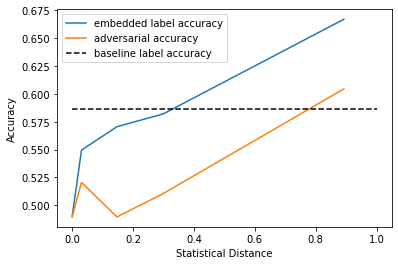

In [20]:
plt.plot(stat_dists, embedded_label_accs, label='embedded label accuracy')
plt.plot(stat_dists, adversary_accs, label='adversarial accuracy')

plt.plot(np.linspace(0,1,10),np.ones(10)*baseline_label_acc, 'k--', label='baseline label accuracy')

plt.xlabel('Statistical Distance')
plt.ylabel('Accuracy')

plt.legend()
plt.show()


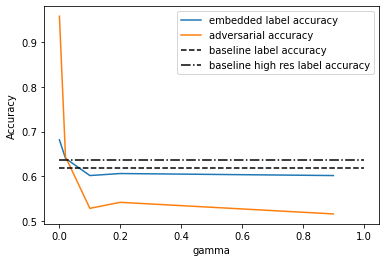

In [115]:
plt.plot(gammas, embedded_label_accs, label='embedded label accuracy')
plt.plot(gammas, adversary_accs, label='adversarial accuracy')
plt.plot(np.linspace(0,1,10),np.ones(10)*baseline_label_acc, 'k--', label='baseline label accuracy')
plt.plot(np.linspace(0,1,10),np.ones(10)*baseline_high_res_label_acc, 'k-.', label='baseline high res label accuracy')


plt.xlabel('gamma')
plt.ylabel('Accuracy')

plt.legend()
# plt.savefig('single_flow_accuracy.png')
plt.show()

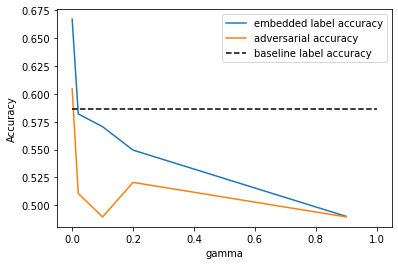

In [21]:
plt.plot(gammas, embedded_label_accs, label='embedded label accuracy')
plt.plot(gammas, adversary_accs, label='adversarial accuracy')
plt.plot(np.linspace(0,1,10),np.ones(10)*baseline_label_acc, 'k--', label='baseline label accuracy')

plt.xlabel('gamma')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

## Look at single gamma

In [131]:
Fair = BinaryFair(data_dim=data_train.shape[-1], 
                    context_dim=data_train.shape[-1],
                    flow_n_layers = 2,
                    flow_transform_type = 'MaskedPiecewiseQuadraticAutoregressiveTransform', 
                    classifier_hidden_dim = 32,
                    classifier_n_layers = 2,
                    classifier_activation = 'ReLU',
                    num_bins = 50,
                    tails='linear',
                    tail_bound=6.0,
                    gamma=0.9
                    )
Fair.fit(label_0_train_generator, label_1_train_generator, probability_flow, n_steps=4000) #4000 is good for now


100%|██████████| 4000/4000 [05:22<00:00, 12.41it/s]


In [132]:
embedding_context_generator, embedding_labels_generator, embedding_data_test, embedding_context_test, embedding_labels_test = get_embedding_data(data_train, labels_train, context_train, data_test, labels_test, context_test, Fairs[0])

# adv_classifier = BinaryClassifier(data_dim=data_train.shape[-1])    
# adv_classifier.fit(embedding_context_generator)
# embedded_label_classifier = BinaryClassifier(data_dim=data_train.shape[-1])
# embedded_label_classifier.fit(embedding_labels_generator)

# print((embedded_label_classifier.accuracy(embedding_data_test, embedding_labels_test)))
# print((adv_classifier.accuracy(embedding_data_test, embedding_context_test)))

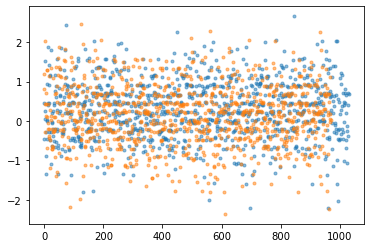

In [133]:
plt.plot(data_test[context_test==1],'.', label='label 1', alpha=0.5)
plt.plot(data_test[context_test==0],'.', label='label 0', alpha=0.5)

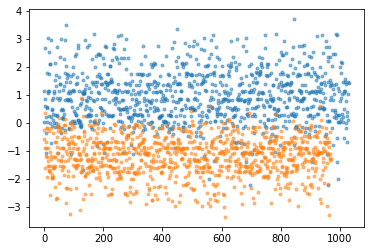

In [134]:
#_transform
plt.plot(embedding_data_test[embedding_context_test==1],'.', label='label 1', alpha=0.5)
plt.plot(embedding_data_test[embedding_context_test==0],'.', label='label 0', alpha=0.5)

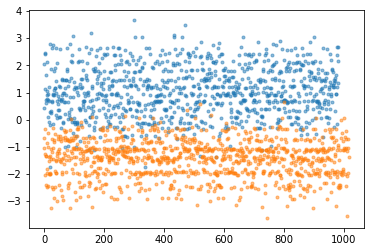

In [103]:
#_fair_forward
plt.plot(embedding_data_test[embedding_context_test==1],'.', label='label 1', alpha=0.5)
plt.plot(embedding_data_test[embedding_context_test==0],'.', label='label 0', alpha=0.5)

In [85]:
Fair.gamma

0.9